# 8. PyTorch Paper Replicating

The goal fo machine learning reserach paper relicatin gis to turn a ML reserach paper into usable code

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture / paper with PyTorch

Resource: https://www.learnpytorch.io/08_pytorch_paper_replicating/

## 0. Get setup

Let's import code we've previously written + required libraries

In [1]:
# Import libraries
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

import matplotlib.pylab as plt

from src import get_data, setup_data, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)
device

'mps'

## 1. Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem

In [3]:
# Download data
get_data.get_data(
    data_dir_str="data",
    image_path_str="pizza_steak_sushi",
    data_url_str="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    file_name_str="pizza_steak_sushi.zip",
)

data/pizza_steak_sushi exists...
Data in data/pizza_steak_sushi already exits, skipping downloading and unzipping...
Finished getting data...


In [4]:
# Setup directories
from pathlib import Path

train_dir = Path("data/pizza_steak_sushi/train")
test_dir = Path("data/pizza_steak_sushi/test")

In [5]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Dataset and DataLoaders

In [6]:
# Create image size
IMG_SIZE = 224 # comes from Table 3 of ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [7]:
# Create a batch size of 32 (paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
    num_workers=1
)

In [8]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from batch
image, label = image_batch[0], label_batch[0]

# View batch shapes
image.shape, label

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

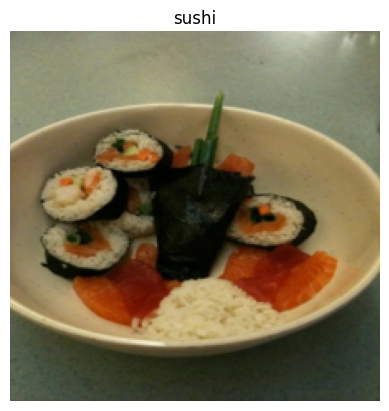

In [10]:
# Plot image with matplotlib

plt.imshow(image.permute(1, 2, 0)) # [color_channels, height, width] -> [height, width, color_channel]
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT

Lookin at the whole machine learning reserach paper can be imtimidating

So in order to make it more understandable, we can break it down into smaller pieces

* **Inputs** - what goes into the model (in our case, image tensors)
* **Outputs** - what comes out of the model (in our case, we want the model to output image classification label)
* **Layers** - takes an input, manipulates it wuth a functino (for example could be self-attention)
* **Blocks** - collection of layers
* **Model (or architecture)** - collection of blocks

### 3.1 ViT overview

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functinos of each layer / block
* Table 1/3: different hyperparameteres for the architecture / training

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time) 



### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```


**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2 
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3 
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block 
```

**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time 

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```

### Table 1 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16 
* Layers - the number of transformer encoder layers 
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention 


## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???

### 4.1 Calculate input and output shapes by hand

> **Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


In [11]:
# Create evample values
height = 224
width = 224
color_channels = 3
patch_size = 16

In [12]:
# Calulcate number of pathes
number_of_pathes = int((height * width)  / patch_size ** 2)
number_of_pathes

196

In [13]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_input_shape

(224, 224, 3)

In [14]:
# Output shape
embedding_layer_output_shape = (number_of_pathes, patch_size ** 2 * color_channels)
embedding_layer_output_shape

(196, 768)

### 4.2 Turning a single image into patches

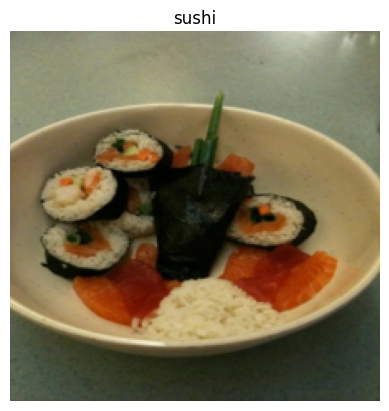

In [15]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

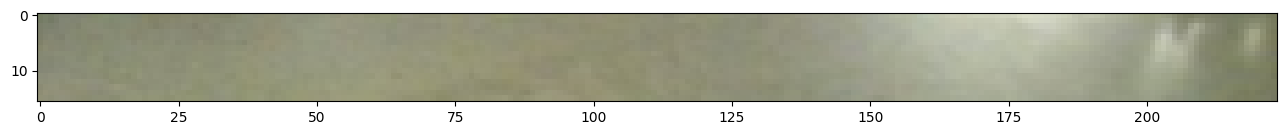

In [16]:
# Get top row of image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [17]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"

num_patches, patch_size

(14.0, 16)

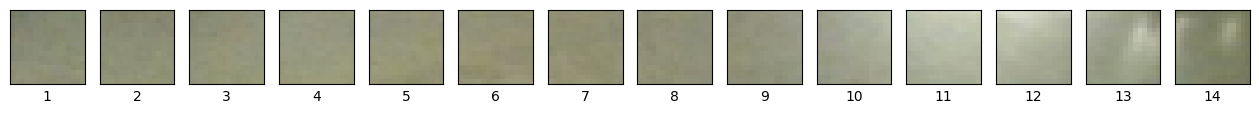

In [18]:
# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,  # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0 ,img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1) # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [19]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"

num_patches, num_patches * num_patches, patch_size

(14.0, 196.0, 16)

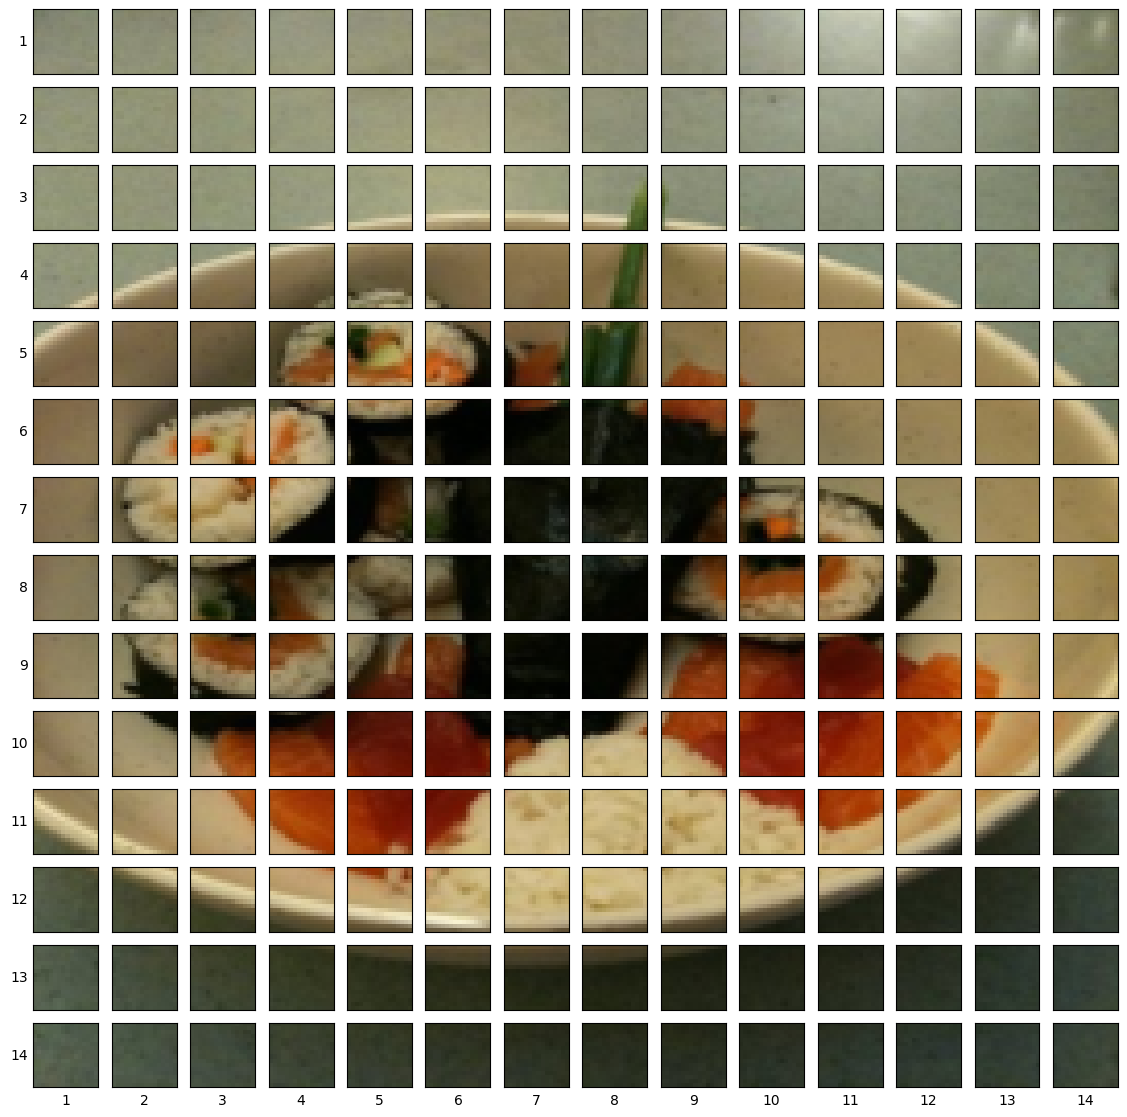

In [20]:
# Create a series of subplot
fix, axs = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         figsize=(num_patches, num_patches),
                         sharex=True,
                         sharey=True,
)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot permuted image on different axes
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])

        axs[i, j].set_ylabel(i+1,
                              rotation="horizontal",
                              horizontalalignment="right",
                              verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
    
fig.suptitle(f"{class_names[label]}")
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

We could create the image patches and image patch embedding in a single step using `torch.nn.Conv2D()` and setting the kernel size and stride values to `patch_size`

In [26]:
# Create conv2d layer to trun image into patches of learnable feature map (embeddings)

# set patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

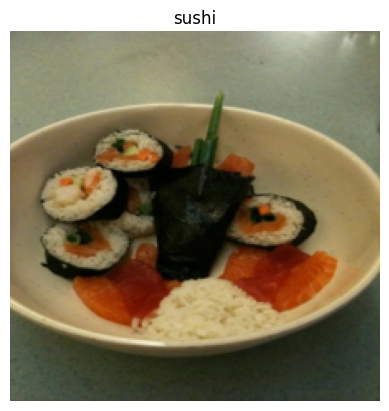

In [27]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [28]:
# View single imagePass imaeg through convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [29]:
14 * 14

196

Now we've passed a single image to our `conv2d` layer, it's hape is: `torch.Size([1, 768, 14, 14])` - `[batch_size, embedding_dim, patch_size, patch_size]`

In [31]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [62, 375, 219, 71, 315]


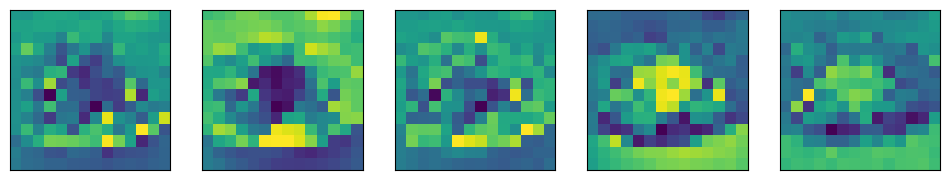

In [40]:
# Plot random convolutional feature maps (embedding)
import random
random_indexes = random.sample(range(0, 758), k=5)

print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dim, remove from grad tracking, switch to numpy
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [41]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0240, -0.0298, -0.0316, -0.0351, -0.0329, -0.0347, -0.0277,
           -0.0188, -0.0309, -0.0434, -0.0356, -0.0323, -0.0889, -0.0621],
          [-0.0355, -0.0401, -0.0392, -0.0395, -0.0426, -0.0323, -0.0112,
           -0.0276, -0.0334, -0.0498, -0.0320, -0.0281, -0.0204, -0.0240],
          [-0.0438, -0.0316, -0.0419, -0.0078, -0.0440, -0.0482, -0.0208,
           -0.0040,  0.0521, -0.0381, -0.0267, -0.0231, -0.0300, -0.0204],
          [-0.0069, -0.0293, -0.1632, -0.0096, -0.0153, -0.0722, -0.0416,
           -0.0346, -0.0182, -0.1259, -0.1198,  0.0481, -0.0525, -0.0136],
          [-0.0082, -0.0220, -0.0266, -0.0222,  0.0139,  0.1624, -0.0789,
           -0.1189, -0.1036, -0.0546, -0.0565, -0.0195, -0.0800,  0.0095],
          [-0.0330, -0.0579, -0.1612,  0.0512,  0.0484,  0.0063,  0.0087,
            0.0904, -0.0746, -0.0983, -0.0512, -0.0552, -0.0412, -0.1587],
          [-0.0176, -0.0223, -0.1075,  0.0402, -0.0204, -0.0099, -0.0344,
            0.0201, -0.0764, -0.

### 4.4 Flattening patch embedding with `torch.nn.Flatten()`

Right now we've a seires of convolutional feature map (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy criteria of the ViT Transformer Encoder

In [46]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_hegiht, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_hegiht, feature_map_width)


In [ ]:
flatten_layer = nn.Flatten(start_dim=2, 
                           end_dim=3)
flatten_layer

Flatten(start_dim=2, end_dim=3)

In [49]:
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])


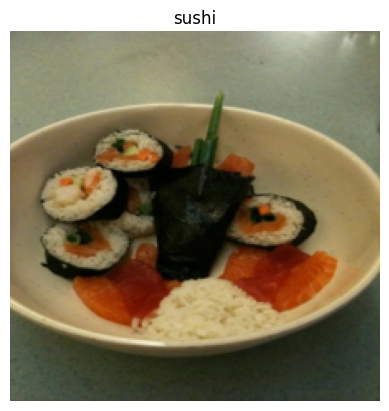

In [50]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

In [51]:
# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

Image feature map (patches) shape: torch.Size([1, 768, 14, 14])


In [52]:
# Flatten feature map
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 196])


In [58]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)

print(f"Permuted image feature map shape: {image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

Permuted image feature map shape: torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


In [60]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[: ,:, 0]
single_flattened_feature_map

tensor([[-0.0240, -0.0298, -0.0316, -0.0351, -0.0329, -0.0347, -0.0277, -0.0188,
         -0.0309, -0.0434, -0.0356, -0.0323, -0.0889, -0.0621, -0.0355, -0.0401,
         -0.0392, -0.0395, -0.0426, -0.0323, -0.0112, -0.0276, -0.0334, -0.0498,
         -0.0320, -0.0281, -0.0204, -0.0240, -0.0438, -0.0316, -0.0419, -0.0078,
         -0.0440, -0.0482, -0.0208, -0.0040,  0.0521, -0.0381, -0.0267, -0.0231,
         -0.0300, -0.0204, -0.0069, -0.0293, -0.1632, -0.0096, -0.0153, -0.0722,
         -0.0416, -0.0346, -0.0182, -0.1259, -0.1198,  0.0481, -0.0525, -0.0136,
         -0.0082, -0.0220, -0.0266, -0.0222,  0.0139,  0.1624, -0.0789, -0.1189,
         -0.1036, -0.0546, -0.0565, -0.0195, -0.0800,  0.0095, -0.0330, -0.0579,
         -0.1612,  0.0512,  0.0484,  0.0063,  0.0087,  0.0904, -0.0746, -0.0983,
         -0.0512, -0.0552, -0.0412, -0.1587, -0.0176, -0.0223, -0.1075,  0.0402,
         -0.0204, -0.0099, -0.0344,  0.0201, -0.0764, -0.2749,  0.1377, -0.2276,
         -0.0545, -0.0575, -

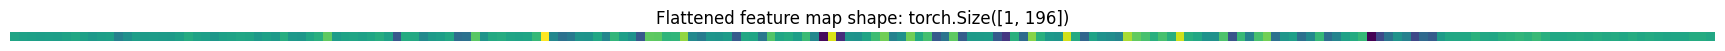

In [62]:
# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)
plt.show()